## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Intro</p>

That's my solution to the Playground Series - Season 3, Episode 7 challenge. 
You'll see:
- Some EDA and Feature Engineering;
- Preliminar model selection with Lazypredict;
- Ensemble training with Optuna optimization;
- Submission


Kudos to: 
- **Sergey Sakharovskiy** for the notebook style css. This is the [github repo](https://github.com/SergeySakharovskiy/jupyter-themes-css)
- **Alexander Shumilin** for the [ensemble notebook](https://www.kaggle.com/code/alexandershumilin/ps-s3-e7-ensemble-model)


In [1]:
# css magic :)
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


### Imports

In [2]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from collections import Counter
!pip install lazypredict -qqqq

from tqdm.auto import tqdm
import math


from lazypredict.Supervised import LazyClassifier

from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import catboost
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization

from xgboost import XGBClassifier

tqdm.pandas()

rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [3]:
# Data
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/reservation-cancellation-prediction/train__dataset.csv
/kaggle/input/reservation-cancellation-prediction/test___dataset.csv
/kaggle/input/playground-series-s3e7/sample_submission.csv
/kaggle/input/playground-series-s3e7/train.csv
/kaggle/input/playground-series-s3e7/test.csv


In [4]:
do_lazypredict=False

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">EDA</p>


In [5]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e7/train.csv', index_col='id')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e7/test.csv', index_col='id')
original_df = pd.read_csv('/kaggle/input/reservation-cancellation-prediction/train__dataset.csv')

full = pd.concat([train_df,original_df])
full = full.reset_index(drop=True)

features = test_df.columns.to_list()
target = 'booking_status'

In [6]:
train_df.describe().T.style.background_gradient(subset=['std'], cmap='Greens').background_gradient(subset=['mean'], cmap='Reds')

,count,mean,std,min,25%,50%,75%,max
no_of_adults,42100.00,1.92,0.52,0.00,2.00,2.00,2.00,4.00
no_of_children,42100.00,0.14,0.45,0.00,0.00,0.00,0.00,9.00
no_of_weekend_nights,42100.00,0.88,0.89,0.00,0.00,1.00,2.00,7.00
no_of_week_nights,42100.00,2.40,1.43,0.00,1.00,2.00,3.00,17.00
type_of_meal_plan,42100.00,0.24,0.59,0.00,0.00,0.00,0.00,3.00
required_car_parking_space,42100.00,0.03,0.16,0.00,0.00,0.00,0.00,1.00
room_type_reserved,42100.00,0.43,0.83,0.00,0.00,0.00,1.00,6.00
lead_time,42100.00,103.89,81.07,0.00,37.00,93.00,155.00,443.00
arrival_year,42100.00,2017.86,0.35,2017.00,2018.00,2018.00,2018.00,2018.00
arrival_month,42100.00,7.59,2.83,1.00,6.00,8.00,10.00,12.00


In [7]:
full.describe().T.style.background_gradient(subset=['std'], cmap='Greens').background_gradient(subset=['mean'], cmap='Reds')

,count,mean,std,min,25%,50%,75%,max
no_of_adults,60237.00,1.90,0.52,0.00,2.00,2.00,2.00,4.00
no_of_children,60237.00,0.13,0.44,0.00,0.00,0.00,0.00,9.00
no_of_weekend_nights,60237.00,0.86,0.88,0.00,0.00,1.00,2.00,7.00
no_of_week_nights,60237.00,2.34,1.43,0.00,1.00,2.00,3.00,17.00
type_of_meal_plan,60237.00,0.26,0.60,0.00,0.00,0.00,0.00,3.00
required_car_parking_space,60237.00,0.03,0.16,0.00,0.00,0.00,0.00,1.00
room_type_reserved,60237.00,0.40,0.82,0.00,0.00,0.00,1.00,6.00
lead_time,60237.00,98.31,83.21,0.00,30.00,81.00,150.00,443.00
arrival_year,60237.00,2017.85,0.36,2017.00,2018.00,2018.00,2018.00,2018.00
arrival_month,60237.00,7.55,2.91,1.00,5.00,8.00,10.00,12.00


In [8]:
set(original_df.columns)==set(train_df.columns)==set(original_df.columns).intersection(set(train_df.columns))

True

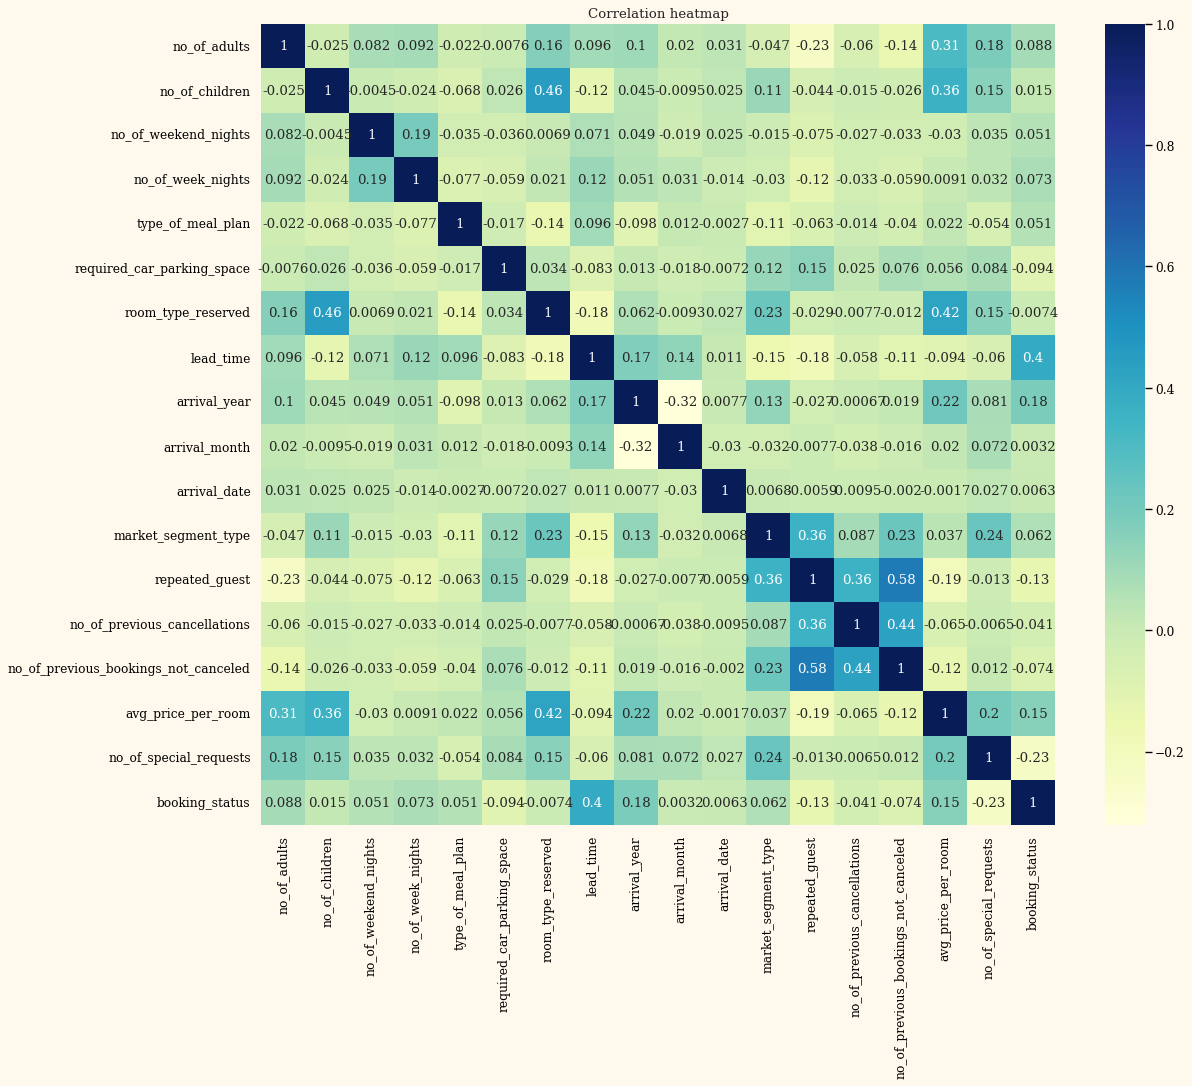

In [9]:
plt.figure(figsize=(16, 13), dpi=80)
sns.heatmap(full.corr(), cmap="YlGnBu", annot=True)
plt.title('Correlation heatmap')
plt.show()

<div class='alert alert-block alert-success'><b>Insights:</b>
    
- The only features that does present a relevant correlation wiht the target value **booking_status** is **lead time**:he time between a guest confirming a reservation at your hotel, and their arrival date. A longer lead time can help you anticipate revenues and optimise resource costs. (https://revenue-hub.com/lead-time-what-is-it-how-to-calculate-it-and-why-it-matters/)

- Both **number_of_childrem** and **room_type_reserved** got a relevant correlation with the avg price. Understandable.
    
- **repeated_guests** and **no_of_previous_bookings_not_cancelled** are highly correlated, of course.
    
    
    
- [Odd one[ **no_of_previous_bookings_not_cancelled** and **no_of_previous_cancellations** are directly correlated.

### Checking for inconsistencies: rows with same features and different target

In [10]:
dups_df=full[full[features].duplicated()]
aux_df=dups_df.groupby(features)['booking_status'].agg(list).reset_index()

In [11]:
def check_if_multivalued(l):
    if(len(set(l))>1):
        return True
    else:
        return False

    
def extract_most_likely_target(L, min_threshold):
    #print(L)
    if len(L)==2:
        return 'indet'
    
    ones=Counter(L)[1]
    zeros=Counter(L)[0]
    
    if ones>zeros:
        if ones/zeros >= min_threshold:
            return 1
        else: 
            return 'indet'
        
    if ones < zeros:
        if zeros/ones >= min_threshold:
            return 0
        else: 
            return 'indet'
        
    if ones == zeros:
        return 'indet'

In [12]:
aux_df['multivalued_booking_status']=aux_df.apply(lambda x : check_if_multivalued(x['booking_status']), axis=1)

aux_df['most_likely_target']=aux_df.apply(lambda x:  extract_most_likely_target(x['booking_status'], 1.5) if x['multivalued_booking_status'] else x['booking_status'][0], axis=1)

aux_df[aux_df['multivalued_booking_status']==True][['most_likely_target', 'booking_status']]

,most_likely_target,booking_status
54,0,"[1, 0, 0]"
92,0,"[0, 0, 1, 0, 1, 0, 1, 0, 0]"
105,0,"[0, 0, 1]"
123,0,"[0, 0, 1]"
184,0,"[1, 0, 0, 0]"
...,...,...
2529,1,"[0, 1, 1]"
2737,indet,"[0, 1]"
2741,indet,"[1, 0]"
2773,indet,"[0, 1]"


In [13]:
aux_df=aux_df[aux_df['most_likely_target']!='indet']
Counter(aux_df['most_likely_target'])

Counter({0: 1683, 1: 1137})

In [14]:
aux_df['booking_status']=aux_df['most_likely_target']
aux_df = aux_df.drop(['multivalued_booking_status', 'most_likely_target'], axis=1)

In [15]:
set(aux_df.columns)==set(full.columns)==set(aux_df.columns).intersection(set(full.columns))

True

In [16]:
full_enh=pd.concat([full[~full[features].duplicated()], aux_df])
full_enh=full_enh.reset_index(drop=True)

In [17]:
TARGET=full_enh["booking_status"].astype(int)
full_enh=full_enh.drop(['booking_status'], axis=1)

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Features eng</p>

### Date and month as cyclic features: polar coordinates 

Can be done using using CyclicalFeatures from feature_engine.creation, i'll do it by hand.

In [18]:
date_features_polar = ['arrival_date_sin', 
                 'arrival_date_cos', 
                 'arrival_month_sin', 
                 'arrival_month_cos']

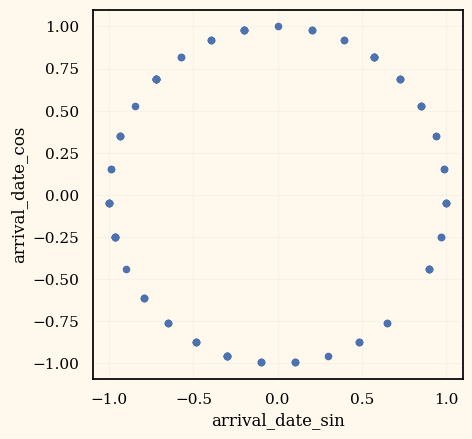

In [19]:
# Day

full_enh['arrival_date_sin'] = np.sin(2 * np.pi * full_enh['arrival_date']/31)
full_enh['arrival_date_cos'] = np.cos(2 * np.pi * full_enh['arrival_date']/31)

test_df['arrival_date_sin'] = np.sin(2 * np.pi * test_df['arrival_date']/31)
test_df['arrival_date_cos'] = np.cos(2 * np.pi * test_df['arrival_date']/31)

full_enh.sample(100).plot.scatter('arrival_date_sin','arrival_date_cos').set_aspect('equal');

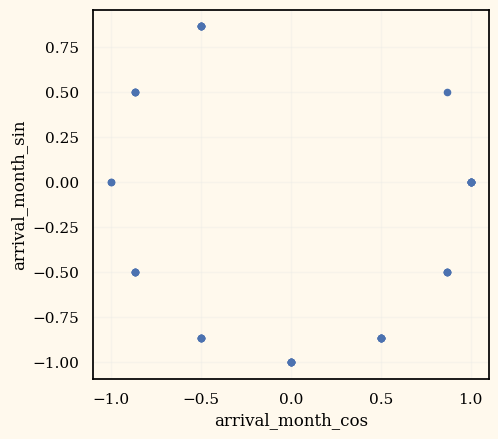

In [20]:
# Month
full_enh['arrival_month_sin'] = np.sin(2 * np.pi * full_enh['arrival_month']/12)
full_enh['arrival_month_cos'] = np.cos(2 * np.pi * full_enh['arrival_month']/12)


test_df['arrival_month_sin'] = np.sin(2 * np.pi * test_df['arrival_month']/12)
test_df['arrival_month_cos'] = np.cos(2 * np.pi * test_df['arrival_month']/12)


full_enh.sample(50).plot.scatter('arrival_month_cos','arrival_month_sin').set_aspect('equal');

In [21]:
full_enh = full_enh.drop(['arrival_month', 'arrival_date'], axis=1)
test_df = test_df.drop(['arrival_month', 'arrival_date'], axis=1)

### Derivative features

In [22]:
full_enh['no_of_adults_div_price'] = full_enh.no_of_adults / (full_enh.avg_price_per_room + 1e-6)
full_enh['no_of_children_div_price'] = full_enh.no_of_children / (full_enh.avg_price_per_room + 1e-6)
full_enh['lead_time_div_price'] = full_enh.lead_time / (full_enh.avg_price_per_room + 1e-6)


test_df['no_of_adults_div_price'] = test_df.no_of_adults / (test_df.avg_price_per_room + 1e-6)
test_df['no_of_children_div_price'] = test_df.no_of_children / (test_df.avg_price_per_room + 1e-6)
test_df['lead_time_div_price'] = test_df.lead_time / (test_df.avg_price_per_room + 1e-6)


In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [24]:
#scaled_df = scaler.fit_transform(full_enh.loc[:,  ~full_enh.columns.isin(date_features_polar)])
scaled_df = scaler.fit_transform(full_enh)
scaled_df = pd.DataFrame(scaled_df)
features_df=scaled_df.rename(columns=dict(zip(scaled_df.columns, full_enh.columns)))

In [25]:
scaled_test_df=scaler.transform(test_df)
scaled_test_df = pd.DataFrame(scaled_test_df)

In [26]:
test_df=scaled_test_df.rename(columns=dict(zip(scaled_test_df.columns, test_df.columns)))

### Cat features WOE TODO

In [27]:
# features

In [28]:
# cat_features = [
#     'required_car_parking_space',
#     'market_segment_type',
#     'room_type_reserved', 
#     'repeated_guest',
#     'type_of_meal_plan'
# ]

# from category_encoders import WOEEncoder

# woe = WOEEncoder(drop_invariant=True, randomized = True)


# for col in cat_features:
#     features_df[col] = features_df[col].astype(str)
    
# woe.fit(features_df[features], features_df['booking_status'], cols = cat_features)
# X = woe.transform(features_df[features])
# X['booking_status'] = features_df['booking_status']
# features_df = X

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Preliminary model selection using Lazypredict</p>

In [29]:
if do_lazypredict:
    X_train, X_test, y_train, y_test = train_test_split(features_df[:20000], TARGET[:20000],test_size=.3,random_state =123)
    clf = LazyClassifier(verbose=0,ignore_warnings=False, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)

    print(models)

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Ensemble: catboost + XGB + LGBM +  RandomForestClassifier</p>



In [30]:
features_list = full_enh.columns
features_list

Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year',
       'market_segment_type', 'repeated_guest', 'no_of_previous_cancellations',
       'no_of_previous_bookings_not_canceled', 'avg_price_per_room',
       'no_of_special_requests', 'arrival_date_sin', 'arrival_date_cos',
       'arrival_month_sin', 'arrival_month_cos', 'no_of_adults_div_price',
       'no_of_children_div_price', 'lead_time_div_price'],
      dtype='object')

### Catboost Classifier


In [31]:
GRID_CATBOOST= False

In [32]:
loss='Logloss'
metric = 'AUC'


n_folds = 8
repeats = 7  

cv = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats = repeats, random_state=2023)

X = features_df[features_list]
X_ts = test_df[features_list]
y = TARGET

if GRID_CATBOOST:
    def objective(trial):
        param = {
            #'task_type':method,
            #"loss_function":trial.suggest_categorical("loss_function", [objective]),
            'eval_metric':trial.suggest_categorical("eval_metric", [metric]) ,
            "rsm":trial.suggest_float("rsm", 0.5, 1),
            'use_best_model':trial.suggest_categorical("use_best_model", [True]) ,
            "iterations":trial.suggest_int("iterations", 100, 5000),
            "learning_rate":trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
            "depth":trial.suggest_int("depth", 4, 9),
            "l2_leaf_reg":trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
            "bootstrap_type":trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
            "random_strength":trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
            "bagging_temperature":trial.suggest_float("bagging_temperature", 0.0, 10.0),
            "od_type":trial.suggest_categorical("od_type", ["Iter"]),
            "od_wait":trial.suggest_int("od_wait", 200, 200),
           # 'scale_pos_weight':weight[1],
            "verbose":0}
        results=[]
        n_iterations=[]
        for tr_ix, vl_ix in cv.split(features_df, TARGET):
    #         train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
    #         train_y, valid_y = y.iloc[train_index], y.iloc[test_index]

            X_tr, y_tr = X.loc[tr_ix].copy(), y.loc[tr_ix]
            X_vl, y_vl = X.loc[vl_ix].copy(), y.loc[vl_ix]
            #X_ts = test_df[features_list].copy()

            model = catboost.CatBoostClassifier(**param)

            model.fit(X=X_tr, y=y_tr,
                  eval_set=[(X_vl, y_vl)]
                 )


    #         model = CatBoostClassifier(**param).fit(train_X,train_y,
    #                                             eval_set=[(valid_X,valid_y)],
    #                                             verbose=0)  
            result = roc_auc_score(y_vl,model.predict_proba(X_vl)[:,1])
            results.append(result)
        n=sum(results)/len(results)    
        return n

    #if  optuna_study==optuna_models[model_name]:
    study = optuna.create_study(direction = "maximize")
    study.optimize(objective, n_trials=100)
    print('Best trial:', study.best_trial.params)

In [33]:
models_CBoost = []
preds_CBoost = []

cv = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42)

cbc_params ={'loss_function': 'Logloss',
             'eval_metric': 'AUC', 
             'rsm': 0.7142868024752266, 
             'use_best_model': True, 
             'iterations': 2885, 
             'learning_rate': 0.06078374270686661, 
             'depth': 5, 
             'l2_leaf_reg': 66.11920042303014, 
             'bootstrap_type': 'Bayesian', 
             'random_strength': 0.00010035859437417805, 
             'bagging_temperature': 0.2393517906517633,
             'od_type': 'Iter', 
             'od_wait': 200}

for fold, (tr_ix, vl_ix) in enumerate(cv.split(features_df, TARGET)):
    
    X_tr, y_tr = X.loc[tr_ix].copy(), y.loc[tr_ix]
    X_vl, y_vl = X.loc[vl_ix].copy(), y.loc[vl_ix]
    X_ts = test_df[features_list].copy()
    
    
    model = catboost.CatBoostClassifier(**cbc_params)
    
    model.fit(X=X_tr, y=y_tr,
          eval_set=[(X_vl, y_vl)],verbose=0
         )
    models_CBoost.append(model)
    preds_CBoost.append(model.predict_proba(X_ts))


### XGBClassifier

In [36]:
GRID_XGB= False

In [38]:
loss='binary:logistic'
metric='auc'
cv = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=repeats, random_state=42)

if GRID_XGB:
    def objective(trial):
        param = {  
            'tree_method':"hist",
            'objective': loss,
            'eval_metric': metric,
            'lambda': trial.suggest_float('lambda', 0, 10.0),
            'alpha': trial.suggest_float('alpha', 0, 10.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1,1.0),
            'subsample': trial.suggest_float('subsample', 0.2,1.0),
            'learning_rate': trial.suggest_float('learning_rate', 0.001,0.1),
            'n_estimators': trial.suggest_int('n_estimators', 100,5000),
            'max_depth': trial.suggest_categorical('max_depth', [2,3,4,5,6,7,8,9,10]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'num_parallel_tree': trial.suggest_int('num_parallel_tree',1,1),
            'early_stopping_rounds':trial.suggest_int('early_stopping_rounds',200,200),
            #'scale_pos_weight':weight[0],
            }
        for fold, (tr_ix, vl_ix) in enumerate(cv.split(features_df, TARGET)):

            X_tr, y_tr = X.loc[tr_ix].copy(), y.loc[tr_ix]
            X_vl, y_vl = X.loc[vl_ix].copy(), y.loc[vl_ix]
            X_ts = test_df[features_list].copy()

            model = XGBClassifier(**xgbc_params)


            model.fit(X=X_tr, y=y_tr,
                  eval_set=[(X_vl, y_vl)],
                  verbose = 100
                 )
            result = roc_auc_score(valid_y,model.predict_proba(valid_X)[:,1])
            results.append(result)
            n=sum(results)/len(results) 
        return n

    if  optuna_study==optuna_models[model_name]:
        study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                                    direction=direction)
        study.optimize(objective, n_trials=100)
        print('Best trial:', study.best_trial.params)

In [39]:
params_best={'tree_method':"hist",
             'objective': loss,
             'eval_metric': metric,
             'lambda': 6.417838313613652, 
             'alpha': 0.06466776309160505, 
             'colsample_bytree': 0.2623681220943176,
             'subsample': 0.8210548095367018, 
             'learning_rate': 0.05396058842899194, 
             'n_estimators': 2102, 
             'max_depth': 9, 
             'min_child_weight': 3, 
             'num_parallel_tree': 1, 
             'early_stopping_rounds': 200}

In [40]:
models_XGB = []
preds_XGB = []

xgbc_params = params_best

for fold, (tr_ix, vl_ix) in enumerate(cv.split(features_df, TARGET)):
    
    X_tr, y_tr = X.loc[tr_ix].copy(), y.loc[tr_ix]
    X_vl, y_vl = X.loc[vl_ix].copy(), y.loc[vl_ix]
    X_ts = test_df[features_list].copy()
    
    model = XGBClassifier(**xgbc_params)

    model.fit(X=X_tr, y=y_tr,
          eval_set=[(X_vl, y_vl)],
          verbose = 100
         )
    models_XGB.append(model)
    preds_XGB.append(model.predict_proba(X_ts))

[0]	validation_0-auc:0.67213
[100]	validation_0-auc:0.88968
[200]	validation_0-auc:0.89962
[300]	validation_0-auc:0.90244
[400]	validation_0-auc:0.90373
[500]	validation_0-auc:0.90470
[600]	validation_0-auc:0.90547
[700]	validation_0-auc:0.90595
[800]	validation_0-auc:0.90614
[900]	validation_0-auc:0.90592
[1000]	validation_0-auc:0.90595
[1003]	validation_0-auc:0.90594
[0]	validation_0-auc:0.67186
[100]	validation_0-auc:0.89642
[200]	validation_0-auc:0.90671
[300]	validation_0-auc:0.90935
[400]	validation_0-auc:0.91062
[500]	validation_0-auc:0.91148
[600]	validation_0-auc:0.91182
[700]	validation_0-auc:0.91206
[800]	validation_0-auc:0.91201
[863]	validation_0-auc:0.91203
[0]	validation_0-auc:0.67954
[100]	validation_0-auc:0.89525
[200]	validation_0-auc:0.90570
[300]	validation_0-auc:0.90824
[400]	validation_0-auc:0.91030
[500]	validation_0-auc:0.91096
[600]	validation_0-auc:0.91135
[700]	validation_0-auc:0.91151
[800]	validation_0-auc:0.91174
[900]	validation_0-auc:0.91147
[1000]	valid

### LGBMClassifier

In [41]:
GRID_LGBM=False

In [42]:
metric = 'auc'

if GRID_LGBM:
    def objective(trial):
        param = {
         "metric":trial.suggest_categorical("metric", [metric]), 
         'verbosity': -1,
         'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
         'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
         'learning_rate': trial.suggest_float('learning_rate', 0.001,0.1),
         'num_leaves': trial.suggest_int('num_leaves', 2, 512),
         'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
         'early_stopping_round' : trial.suggest_int('early_stopping_round', 300, 300),
         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
         'n_estimators' : trial.suggest_int('n_estimators', 100, 5000),
         "subsample":trial.suggest_categorical("subsample", [None]),
         "subsample_freq":trial.suggest_categorical("subsample_freq", [None]),
         "reg_alpha":trial.suggest_categorical("reg_alpha", [None]),
         "colsample_bytree":trial.suggest_categorical("colsample_bytree", [None]),
         "reg_lambda":trial.suggest_categorical("reg_lambda", [None]),
         'class_weight':weights
                 }


        for fold, (tr_ix, vl_ix) in enumerate(cv.split(features_df, TARGET)):

            X_tr, y_tr = X.loc[tr_ix].copy(), y.loc[tr_ix]
            X_vl, y_vl = X.loc[vl_ix].copy(), y.loc[vl_ix]
            X_ts = test_df[features_list].copy()

            model = LGBMClassifier(**xgbc_params)

            model.fit(X=X_tr, y=y_tr,
                  eval_set=[(X_vl, y_vl)],
                  verbose = 100
                 )
            result = roc_auc_score(valid_y,model.predict_proba(valid_X)[:,1])
            results.append(result)
            n=sum(results)/len(results)   
        return n

    if  optuna_study == optuna_models[model_name]:
        study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                                    direction=direction)
        study.optimize(objective, n_trials=100)
        print('Best trial:', study.best_trial.params)

In [43]:
params_best={'metric': 'auc', 
             'lambda_l1': 2.3671616806517433, 
             'lambda_l2': 1.992333699228129, 
             'learning_rate': 0.00593865355299753, 
             'num_leaves': 245, 
             'feature_fraction': 0.4249996497230429, 
             'bagging_fraction': 0.6535554308740741, 
             'early_stopping_round': 300, 
             'bagging_freq': 5, 
             'min_child_samples': 15, 
             'n_estimators': 4212, 
             'subsample': None, 
             'subsample_freq': None, 
             'reg_alpha': None, 
             'colsample_bytree': None, 
             'reg_lambda': None}

In [ ]:
import lightgbm as lgbm

models_LGBM = []
preds_LGBM = []

gbc_params = {'metric': 'auc', 
             'lambda_l1': 2.3671616806517433, 
             'lambda_l2': 1.992333699228129, 
             'learning_rate': 0.00593865355299753, 
             'num_leaves': 245, 
             'feature_fraction': 0.4249996497230429, 
             'bagging_fraction': 0.6535554308740741, 
             'early_stopping_round': 300, 
             'bagging_freq': 5, 
             'min_child_samples': 15, 
             'n_estimators': 4212, 
             'subsample': None, 
             'subsample_freq': None, 
             'reg_alpha': None, 
             'colsample_bytree': None, 
             'reg_lambda': None}

for fold, (tr_ix, vl_ix) in enumerate(cv.split(features_df, TARGET)):
    
    X_tr, y_tr = X.loc[tr_ix].copy(), y.loc[tr_ix]
    X_vl, y_vl = X.loc[vl_ix].copy(), y.loc[vl_ix]
    X_ts = test_df[features_list].copy()
    
    model = lgbm.LGBMClassifier(**gbc_params)
    
    model.fit(X=X_tr, y=y_tr,
          eval_set=[(X_vl, y_vl)],
          callbacks=[lgbm.log_evaluation(period=0, show_stdv=False)],
          verbose = 100
         )
    models_LGBM.append(model)
    preds_LGBM.append(model.predict_proba(X_ts))

[100]	valid_0's auc: 0.887005
[200]	valid_0's auc: 0.889533
[300]	valid_0's auc: 0.892377
[400]	valid_0's auc: 0.894123
[500]	valid_0's auc: 0.895718
[600]	valid_0's auc: 0.897321
[700]	valid_0's auc: 0.898971
[800]	valid_0's auc: 0.900042
[900]	valid_0's auc: 0.90105
[1000]	valid_0's auc: 0.90188
[1100]	valid_0's auc: 0.902636
[1200]	valid_0's auc: 0.903198
[1300]	valid_0's auc: 0.903668
[1400]	valid_0's auc: 0.90401
[1500]	valid_0's auc: 0.904334
[1600]	valid_0's auc: 0.904604
[1700]	valid_0's auc: 0.904821
[1800]	valid_0's auc: 0.904919
[1900]	valid_0's auc: 0.905132
[2000]	valid_0's auc: 0.905271
[2100]	valid_0's auc: 0.905413
[2200]	valid_0's auc: 0.905522
[2300]	valid_0's auc: 0.905607
[2400]	valid_0's auc: 0.905625
[2500]	valid_0's auc: 0.905651
[2600]	valid_0's auc: 0.905681
[2700]	valid_0's auc: 0.905691
[2800]	valid_0's auc: 0.905669
[100]	valid_0's auc: 0.894254
[200]	valid_0's auc: 0.896723
[300]	valid_0's auc: 0.899583
[400]	valid_0's auc: 0.901599
[500]	valid_0's auc: 0.9

### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

models_RFC = []
preds_RFC = []

params_best={'criterion': 'entropy', 
              'n_estimators': 260, 
              'n_jobs': -1, 
              'verbose': 0, 
              'max_depth': 12, 
              'min_samples_split': 3, 
              'min_samples_leaf': 2}

for fold, (tr_ix, vl_ix) in enumerate(cv.split(features_df, TARGET)):
    
    X_tr, y_tr = X.loc[tr_ix].copy(), y.loc[tr_ix]
    X_vl, y_vl = X.loc[vl_ix].copy(), y.loc[vl_ix]
    X_ts = test_df[features_list].copy()
    
    model = RandomForestClassifier(**params_best)
    
    model.fit(X=X_tr, y=y_tr,
          #eval_set=[(X_vl, y_vl)],
          #early_stopping_rounds = PATIENCE,
          #verbose = 100
         )
    models_RFC.append(model)
    preds_RFC.append(model.predict_proba(X_ts))

## Optuna study

In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, cohen_kappa_score

 
def coef_objective(trial):
    a = trial.suggest_float('a', 0, 1)
    b = trial.suggest_float('b', 0, 1)
    c = trial.suggest_float('c', 0, 1)
    d = trial.suggest_float('d', 0, 1)
    
    preds_eval = []
    for model in models_LGBM:
        preds_eval.append(model.predict_proba(X))
    
    res_LGBM = np.average(np.array(preds_eval),axis=0)[:, 1]
    
    preds_eval = []
    for model in models_XGB:
        preds_eval.append(model.predict_proba(X))
    
    res_XGB = np.average(np.array(preds_eval),axis=0)[:, 1]
    
    preds_eval = []
    for model in models_CBoost:
        preds_eval.append(model.predict_proba(X))
    
    res_CBoost = np.average(np.array(preds_eval),axis=0)[:, 1]
    
    
    preds_eval = []
    for model in models_RFC:
        preds_eval.append(model.predict_proba(X))
    
    resRFC = np.average(np.array(preds_eval),axis=0)[:, 1]
    
    res1 =  (res_LGBM * a +
             res_XGB * b + 
             res_CBoost * c+
             resRFC *d)/ (a+ b + c + d)
    
    res = roc_auc_score(TARGET, res1)

    return res

In [ ]:
study = optuna.create_study(direction= 'maximize')

In [ ]:
study.optimize(coef_objective, n_trials= 100)

In [ ]:
study.best_params

In [ ]:
a = study.best_params['a']
b = study.best_params['b']
c = study.best_params['c']
d = study.best_params['d']

sum_coef =  a + b + c + d 

a = a / sum_coef
b = b / sum_coef
c = c / sum_coef
d = d / sum_coef

a, b, c, d

In [ ]:
# res_LGBM * a +
#              res_XGB * b + 
#              res_CBoost * c+
#              resRFC *d

In [ ]:
pred_XBC = np.average(np.array(preds_XGB),axis=0)[:, 1]
pred_CBoost= np.average(np.array(preds_CBoost),axis=0)[:, 1]
pred_LGBM = np.average(np.array(preds_LGBM),axis=0)[:, 1]
pred_RFC = np.average(np.array(preds_RFC),axis=0)[:, 1]

In [ ]:
ensemble_preds = pred_LGBM * a + pred_XBC * b + pred_CBoost * c + pred_RFC *d


## Submission

In [ ]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e7/sample_submission.csv', index_col=0)

In [ ]:
submission['booking_status'] = ensemble_preds

In [ ]:
submission.to_csv('submissions.csv')

In [ ]:
df = pd.read_csv("../input/playground-series-s3e7/train.csv")
test_df = pd.read_csv("../input/playground-series-s3e7/test.csv")

submit = pd.read_csv('submit.csv')

dup_features = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
               'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
               'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
               'arrival_date', 'market_segment_type', 'repeated_guest',
               'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
               'avg_price_per_room', 'no_of_special_requests']

tt = df.rename(columns={"index":"id"}).drop('booking_status', axis=1)
test_leakage = test_df.merge(tt, on=dup_features, how='inner', suffixes=['_test', '_train'])[['id_test', 'id_train']]

test_leakage = df.loc[test_leakage.id_train][['id', 'booking_status']].rename(columns={'id':'id_train'}).merge(test_leakage, on='id_train')


rr = submit.rename(columns={'booking_status': 'prd', 'id':'id_test'}).merge(test_leakage, on='id_test', how='left')
prd_max = rr['prd'].max()
prd_min = rr['prd'].min()


def tmp_fun(x):
    bs = x.booking_status
    if(pd.isna(bs)):
        return x['prd']
    elif(bs == 0):
        return prd_max
    elif(bs == 1):
        return prd_min
    
submit['booking_status'] =  rr.apply(tmp_fun, axis=1)